In [1]:
# Basic imports
import pandas as pd
import numpy as np
import logging
import warnings
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# PyTorch imports
import torch

# PyTorch Tabular and Model imports (replace with correct imports based on your package structure)
from pytorch_tabular import TabularModel
from pytorch_tabular.models.category_embedding import CategoryEmbeddingModel

from pytorch_tabular.categorical_encoders import CategoricalEmbeddingTransformer
import sys
sys.path.append('../')
from src.data.process_data import load_dataset, split_dataset

# Suppress common warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [2]:
# Define the file paths to your datasets

data_path = '../data/'
drug_syn_path = os.path.join(data_path, 'drug_synergy.csv')
cell_lines_path = os.path.join(data_path, 'cell_lines.csv')
drug_portfolio_path = os.path.join(data_path, 'drug_portfolio.csv')

full_dataset_df, column_type_dict = load_dataset(drug_syn_path, cell_lines_path, drug_portfolio_path)

# Split the dataset into training, testing, and leaderboard sets
datasets = split_dataset(full_dataset_df)

categorical_cols = column_type_dict['categorical']['col_names']
continuous_cols = column_type_dict['numerical']['col_names']

In [3]:
# Path to the saved model checkpoint
model_path = "../models_weights/seed_42/CategoryEmbedding_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)





2024-12-02 13:21:46,450 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-02 13:21:46,460 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

In [4]:
X = datasets['train']['X'][categorical_cols]
print(X.columns)
X_trans = transformer.transform(X)
print(X_trans.columns)

Output()

Index(['Cell line name', 'Compound A', 'Compound B',
       'GDSC tissue descriptor 2', 'MSI', 'Growth properties',
       'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B',
       'Function_B', 'Pathway_B'],
      dtype='object')


Index(['Cell line name_embed_dim_0', 'Cell line name_embed_dim_1',
       'Cell line name_embed_dim_2', 'Cell line name_embed_dim_3',
       'Cell line name_embed_dim_4', 'Cell line name_embed_dim_5',
       'Cell line name_embed_dim_6', 'Cell line name_embed_dim_7',
       'Cell line name_embed_dim_8', 'Cell line name_embed_dim_9',
       ...
       'Function_B_embed_dim_1', 'Function_B_embed_dim_2',
       'Function_B_embed_dim_3', 'Pathway_B_embed_dim_0',
       'Pathway_B_embed_dim_1', 'Pathway_B_embed_dim_2',
       'Pathway_B_embed_dim_3', 'Pathway_B_embed_dim_4',
       'Pathway_B_embed_dim_5', 'Pathway_B_embed_dim_6'],
      dtype='object', length=170)


In [5]:

# Dictionary to store unique embeddings for each element in each categorical column
unique_embeddings_dict = {}

for col in categorical_cols:
    # Identify embedding columns related to this categorical column
    embedding_cols = [c for c in X_trans.columns if c.startswith(f"{col}_embed_dim")]
    
    # Combine the original column with its embeddings
    combined_df = pd.concat([X[col].reset_index(drop=True), X_trans[embedding_cols].reset_index(drop=True)], axis=1)
    
    # Create a dictionary for this column where each key is a unique element, and value is the embedding as a numpy array
    col_embeddings = {val: group[embedding_cols].values[0] for val, group in combined_df.groupby(col)}
    
    # Store in the main dictionary
    unique_embeddings_dict[col] = col_embeddings
    
   

unique_embeddings_dict.keys()

dict_keys(['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'MSI', 'Growth properties', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B'])

PCA plot for 'Cell line name':


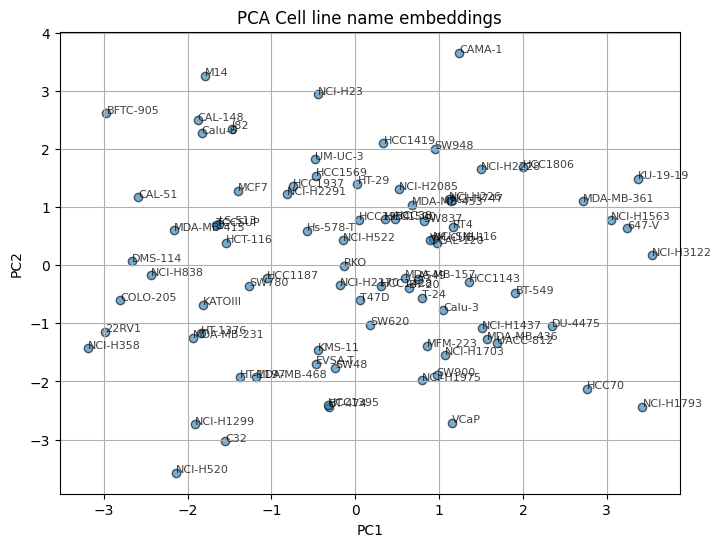

PCA plot for 'Compound A':


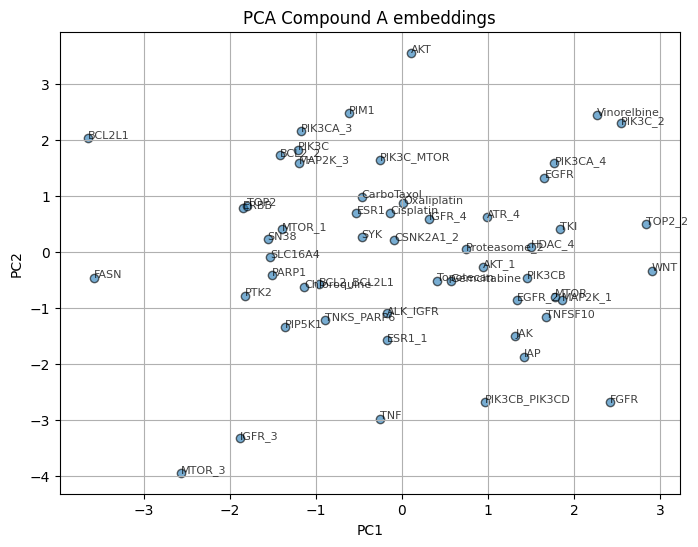

PCA plot for 'Compound B':


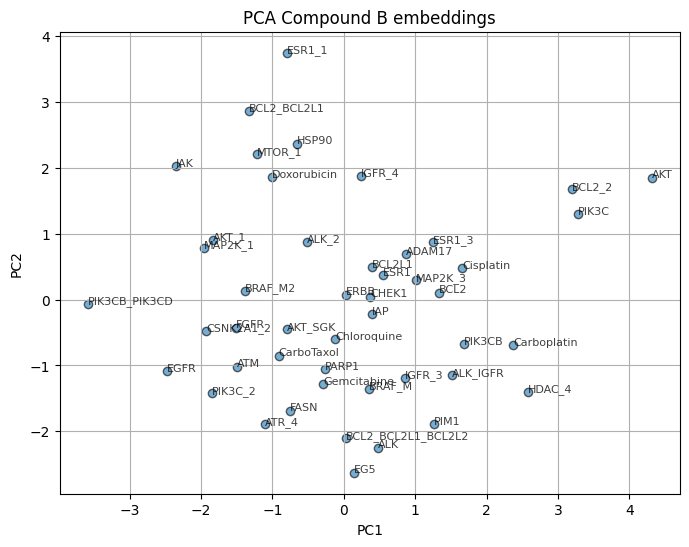

PCA plot for 'GDSC tissue descriptor 2':


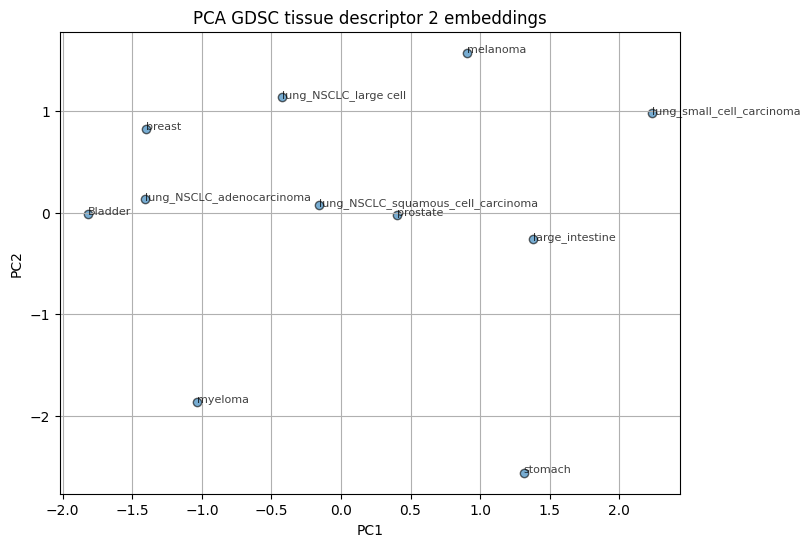

PCA plot for 'Putative target_A':


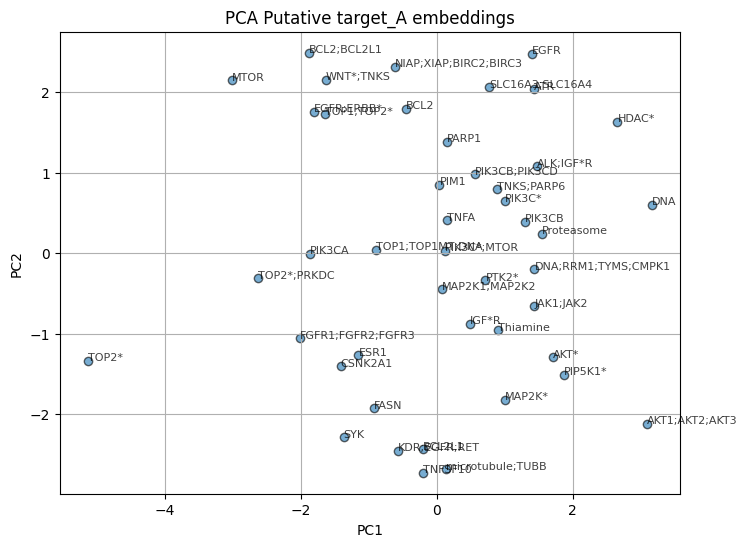

PCA plot for 'Function_A':


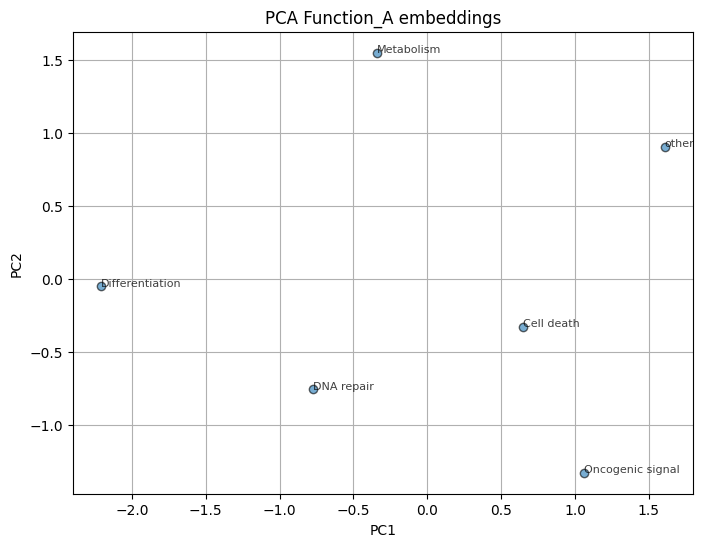

PCA plot for 'Pathway_A':


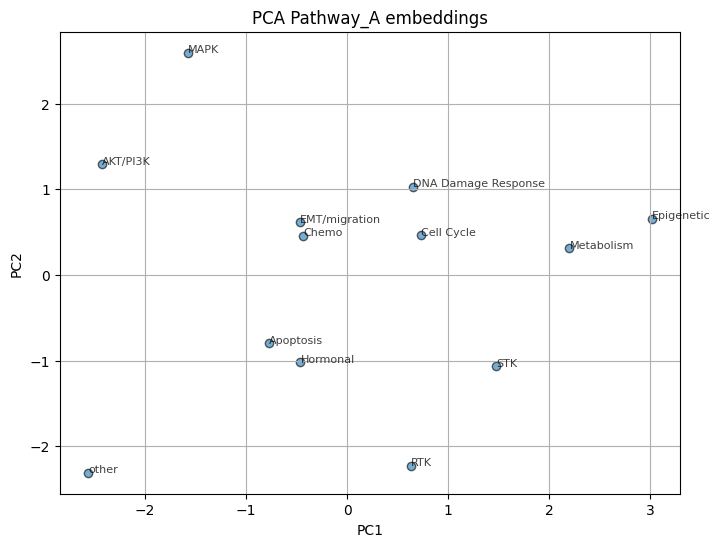

PCA plot for 'Putative target_B':


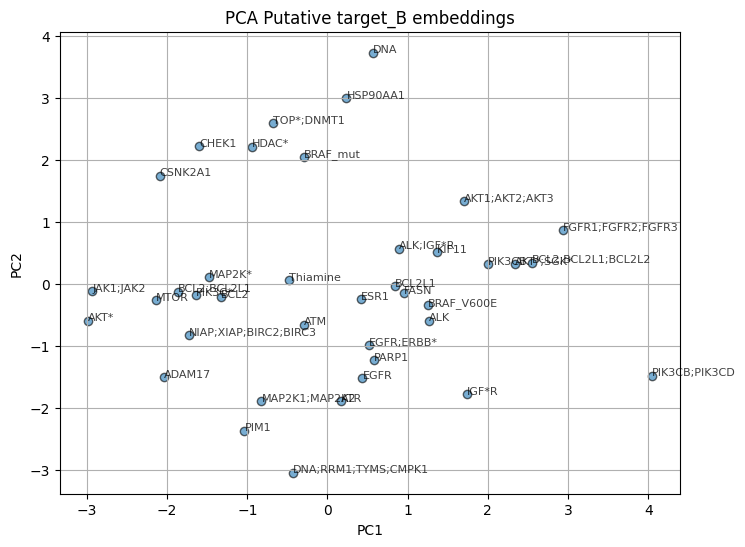

PCA plot for 'Function_B':


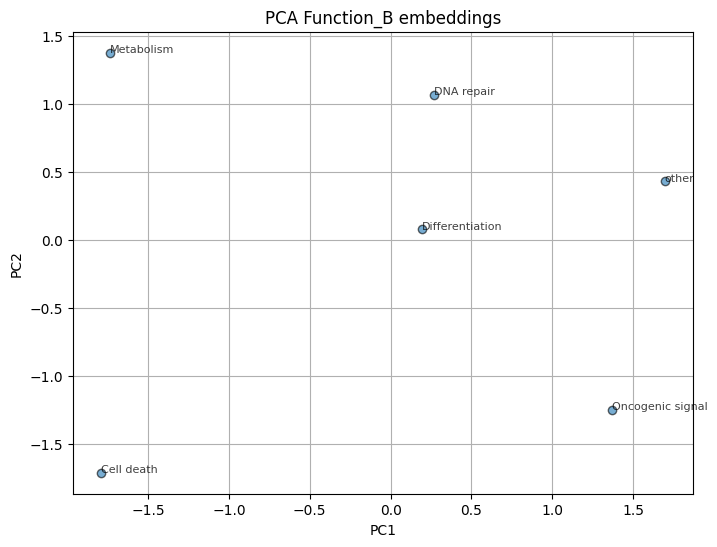

PCA plot for 'Pathway_B':


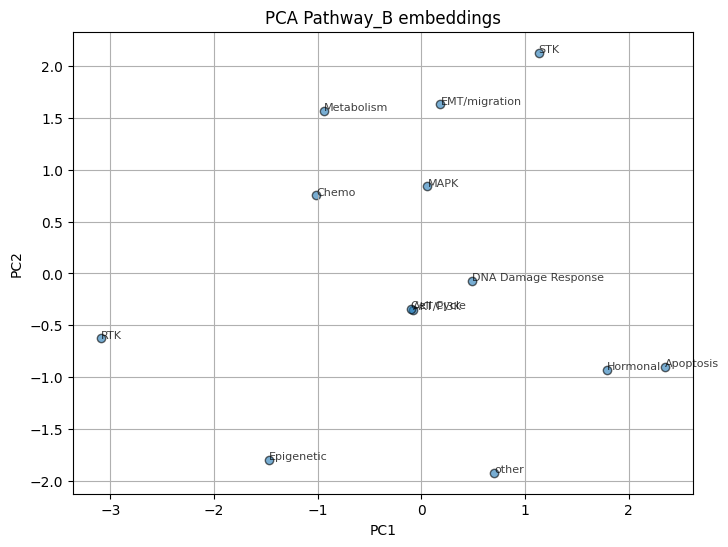

In [6]:


# Function to perform PCA and plot results
def plot_pca_embeddings(embeddings_dict, category_name, n_components=2):
    """
    Applies PCA to the embeddings of a categorical variable and plots the results.

    Parameters:
        embeddings_dict (dict): Dictionary containing unique items and their embeddings as numpy arrays.
        category_name (str): Name of the categorical variable.
        n_components (int): Number of PCA components to retain for plotting.
    """
    # Stack embeddings into a 2D array for PCA
    embeddings = np.stack(list(embeddings_dict.values()))
    labels = list(embeddings_dict.keys())
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    
    # Plotting the PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, edgecolors="k")
    
    # Annotate points with the unique category labels (optional, can be commented out if too crowded)
    for i, label in enumerate(labels):
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.75)
    
    plt.title(f"PCA {category_name} embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

pca_columns = ['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B']
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    print(f"PCA plot for '{category}':")
    plot_pca_embeddings(embeddings, category)


In [7]:
import pandas as pd
import os

# Define the folder to save the dataframes
output_folder = "../data/embeddings/TabNet_model/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Iterate over each category and create/save a DataFrame
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    
    # Prepare data for the DataFrame
    data = {
        category: [label for label in embeddings.keys()],    
    }
    # Add each embedding dimension as a separate column
    for dim in range(len(next(iter(embeddings.values())))):  # Assuming all embeddings have the same dimension
        data[f"embedding_dim_{dim}"] = [embedding[dim] for embedding in embeddings.values()]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_folder, f"{category}_embeddings.csv")
    df.to_csv(output_path, index=False)


PCA plot for 'Cell line name':


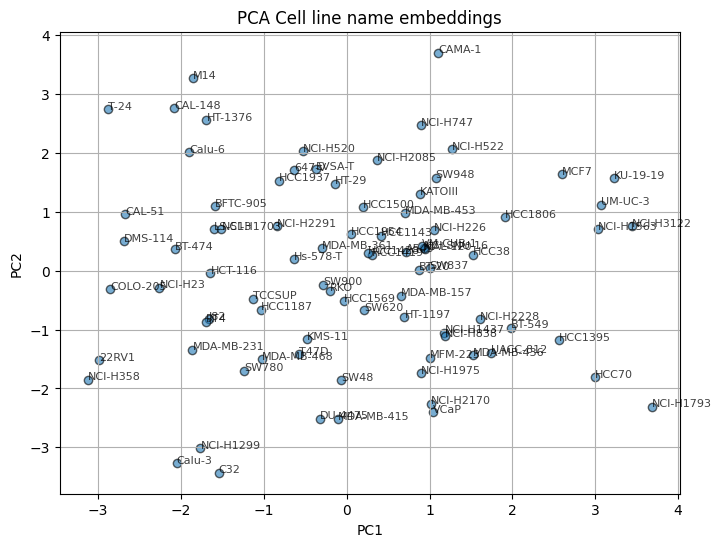

PCA plot for 'Compound A':


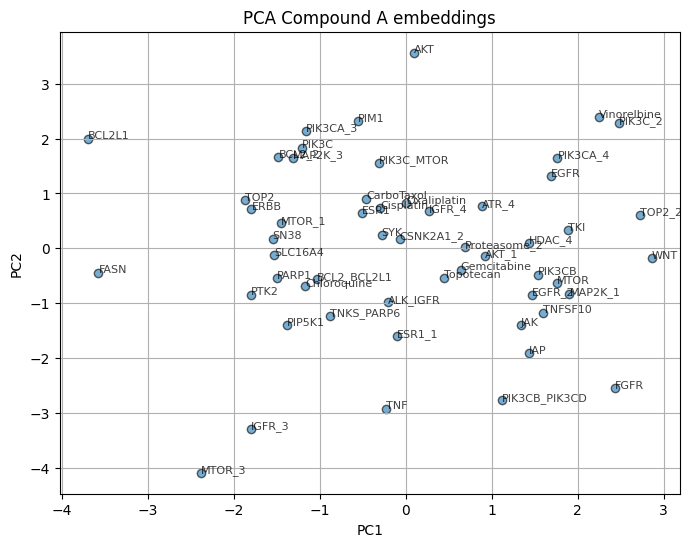

PCA plot for 'Compound B':


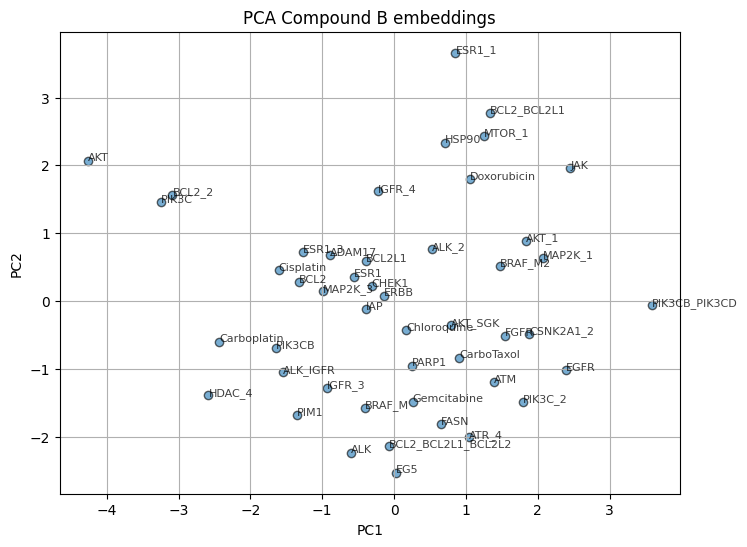

PCA plot for 'GDSC tissue descriptor 2':


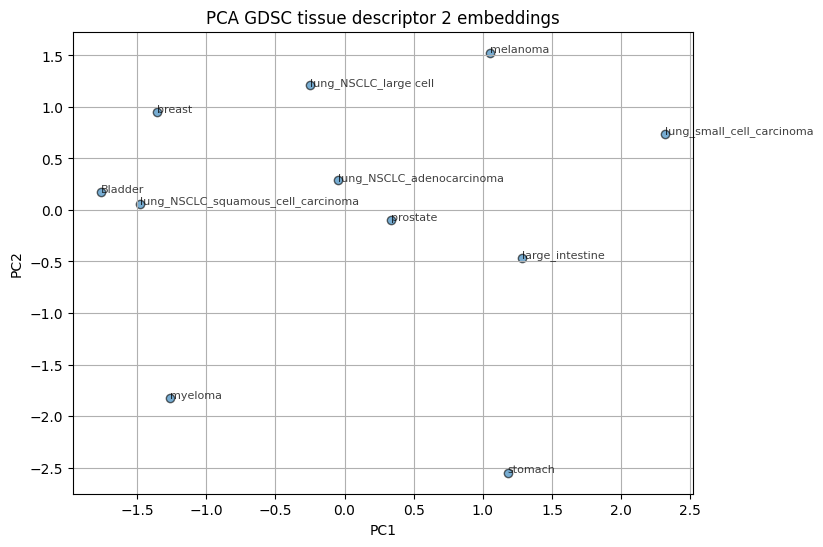

PCA plot for 'Putative target_A':


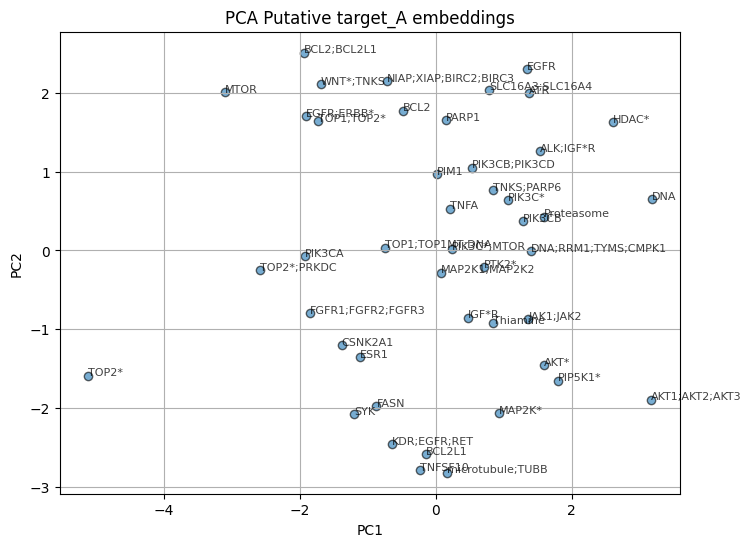

PCA plot for 'Function_A':


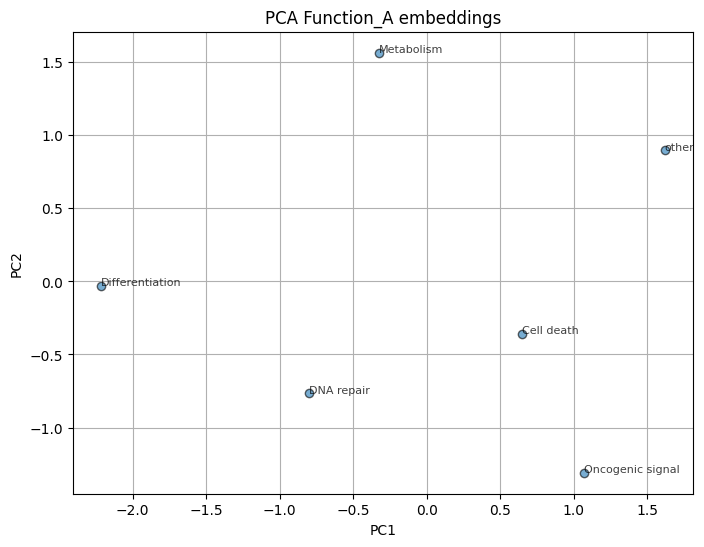

PCA plot for 'Pathway_A':


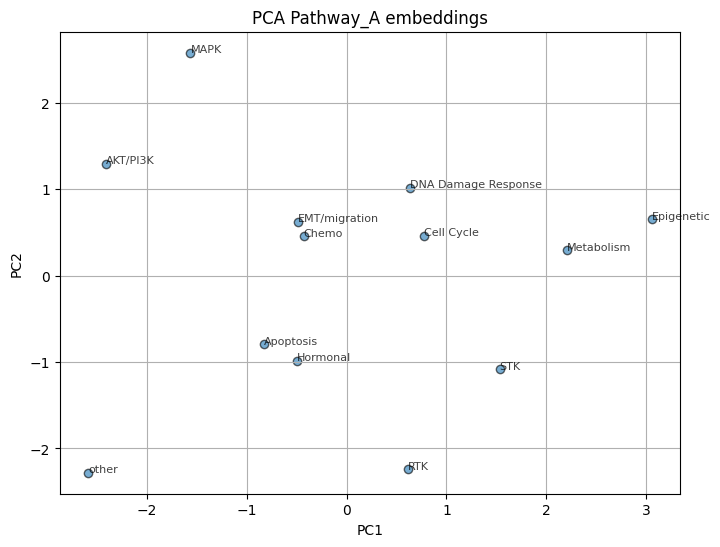

PCA plot for 'Putative target_B':


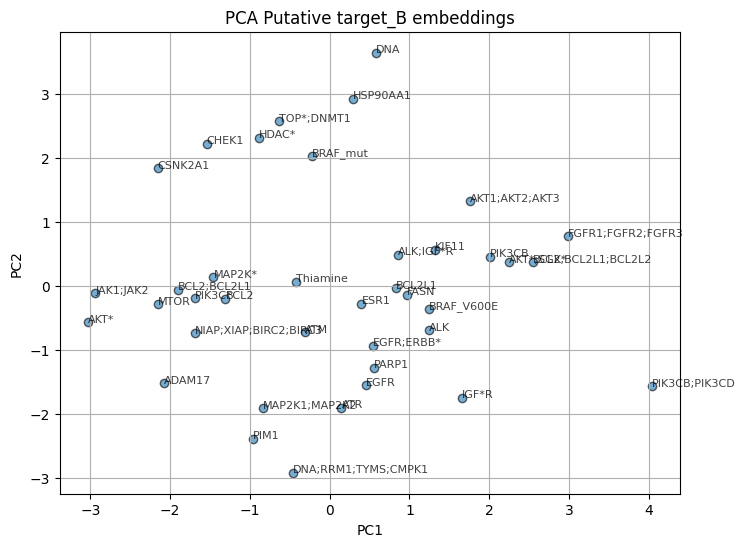

PCA plot for 'Function_B':


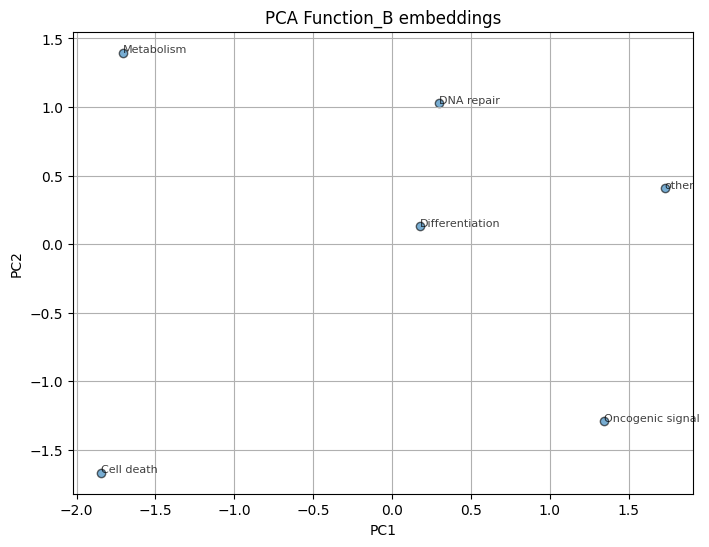

PCA plot for 'Pathway_B':


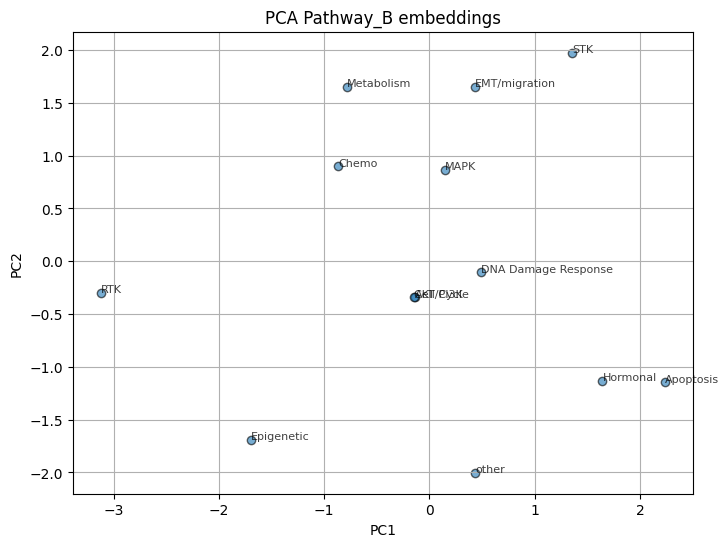

In [8]:
## Plot the PCAs but grouping labels by using other variables.

def plot_pca_embeddings(embeddings_dict, category_name, n_components=2):
    """
    Applies PCA to the embeddings of a categorical variable and plots the results.

    Parameters:
        embeddings_dict (dict): Dictionary containing unique items and their embeddings as numpy arrays.
        category_name (str): Name of the categorical variable.
        n_components (int): Number of PCA components to retain for plotting.
    """
    # Stack embeddings into a 2D array for PCA
    embeddings = np.stack(list(embeddings_dict.values()))
    labels = list(embeddings_dict.keys())
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    
    # Plotting the PCA results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, edgecolors="k")
    
    # Annotate points with the unique category labels (optional, can be commented out if too crowded)
    for i, label in enumerate(labels):
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.75)
    
    plt.title(f"PCA {category_name} embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

pca_columns = ['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B']
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    print(f"PCA plot for '{category}':")
    plot_pca_embeddings(embeddings, category)


In [7]:
def plot_pca_embeddings(embeddings_dict, category_name, groups_dict=None, n_components=2, groups_name="Groups"):
    """
    Applies PCA to the embeddings of a categorical variable and plots the results, 
    coloring points based on specified groups.

    Parameters:
        embeddings_dict (dict): Dictionary containing unique items and their embeddings as numpy arrays.
        category_name (str): Name of the categorical variable.
        groups_dict (dict): Dictionary where keys are group labels (e.g., pathways) and values are lists of items in that group.
        n_components (int): Number of PCA components to retain for plotting.
    """
    # Stack embeddings into a 2D array for PCA
    embeddings = np.stack(list(embeddings_dict.values()))
    labels = list(embeddings_dict.keys())
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(embeddings)
    
    # Plotting setup
    plt.figure(figsize=(10, 8))
    
    # If groups_dict is provided, use it to color the points by group
    if groups_dict:
        for group, items in groups_dict.items():
            indices = [labels.index(item) for item in items if item in labels]
            plt.scatter(pca_result[indices, 0], pca_result[indices, 1], alpha=0.6, label=group, edgecolors="k")
    else:
        # If no groups are provided, plot all points in a single color
        plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, edgecolors="k")

    # Annotate points with the unique category labels (optional)
    for i, label in enumerate(labels):
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.75)
    
    # Plot aesthetics
    plt.title(f"PCA {category_name} embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title=groups_name)

    plt.grid(True)
    plt.show()

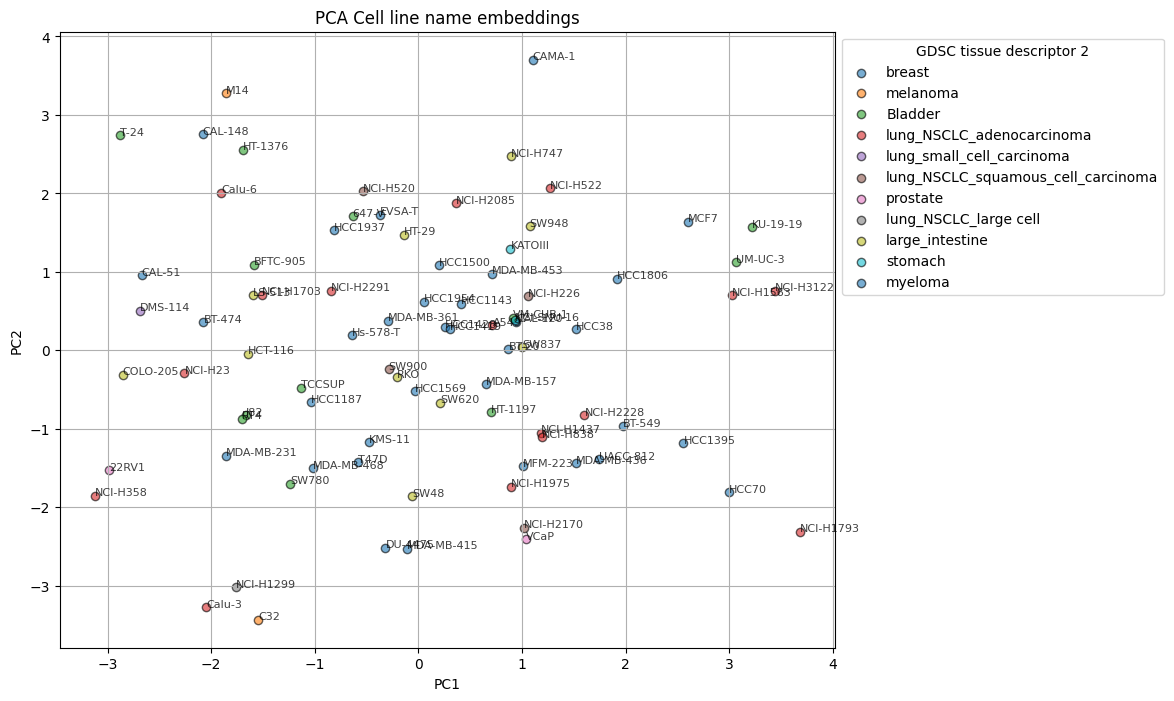

In [10]:
keyname = 'GDSC tissue descriptor 2'
valuename = 'Cell line name'

key_list = full_dataset_df[keyname].unique().tolist()
grouping_dict = dict()
for key in key_list:
    grouping_dict[key] = full_dataset_df[full_dataset_df[keyname] == key][valuename].unique().tolist()

plot_pca_embeddings(unique_embeddings_dict[valuename], valuename, 
                    groups_dict=grouping_dict, n_components=2, groups_name=keyname)

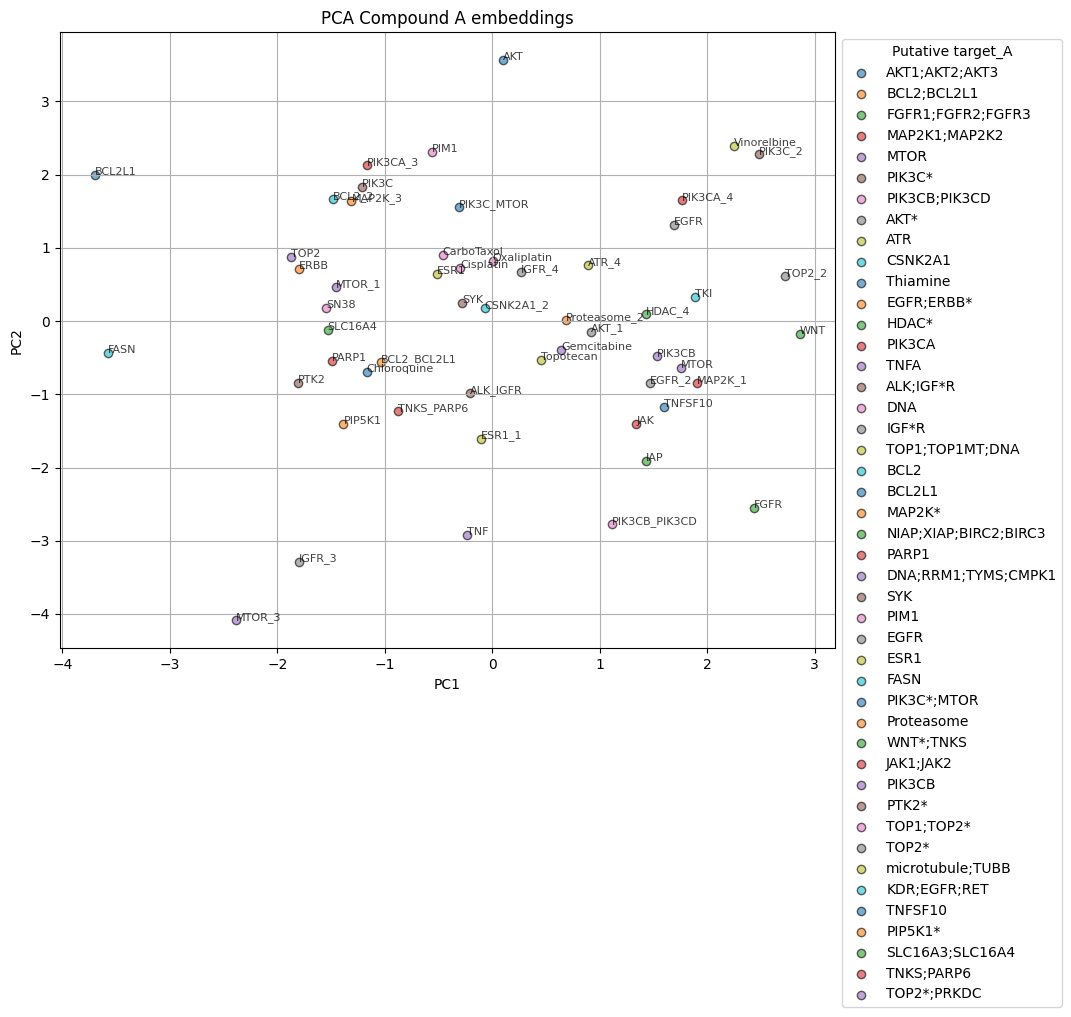

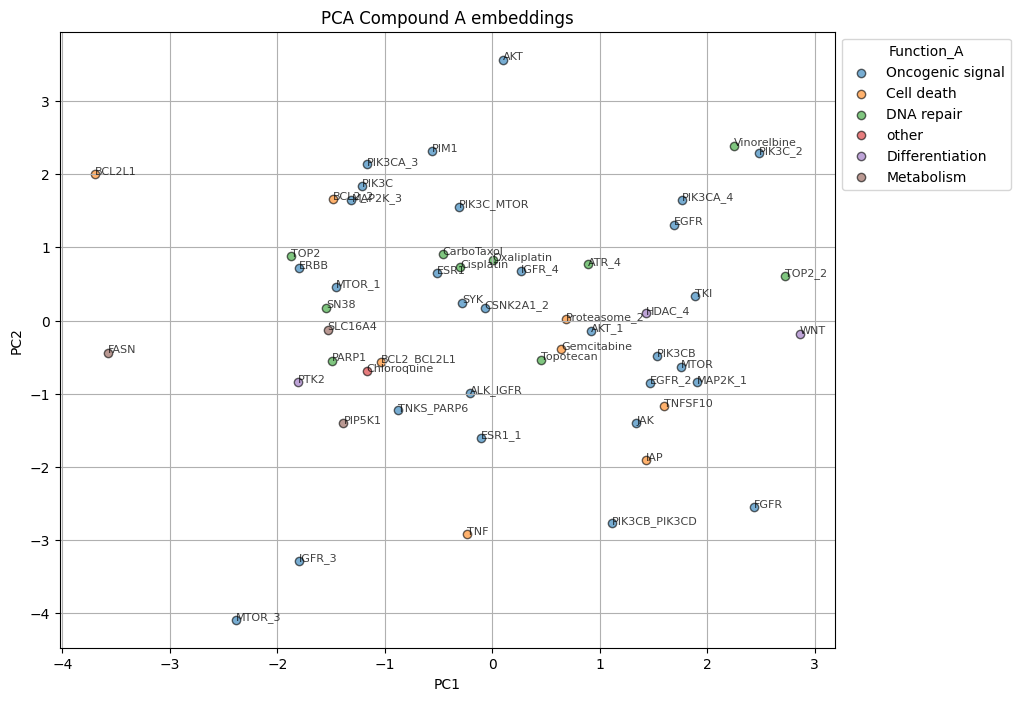

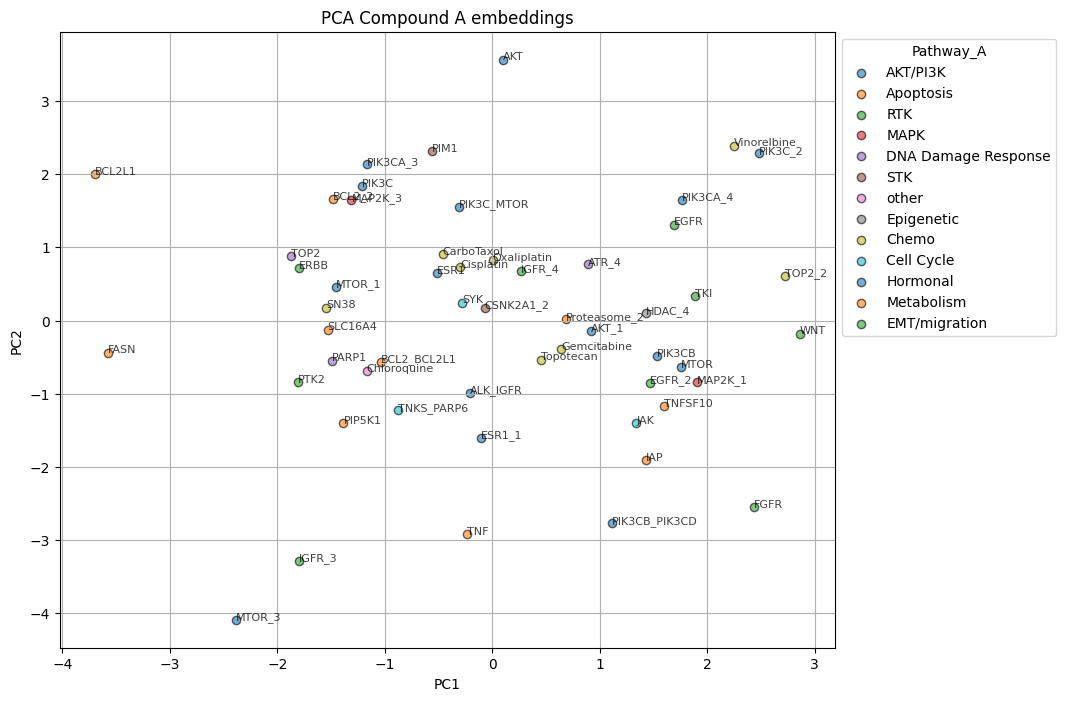

In [11]:
keyname_list = ['Putative target_A', 'Function_A', 'Pathway_A']

valuename = 'Compound A'

for keyname in keyname_list:
    key_list = full_dataset_df[keyname].unique().tolist()
    grouping_dict = dict()
    for key in key_list:
        grouping_dict[key] = full_dataset_df[full_dataset_df[keyname] == key][valuename].unique().tolist()

    plot_pca_embeddings(unique_embeddings_dict[valuename], valuename, 
                        groups_dict=grouping_dict, n_components=2, groups_name=keyname)

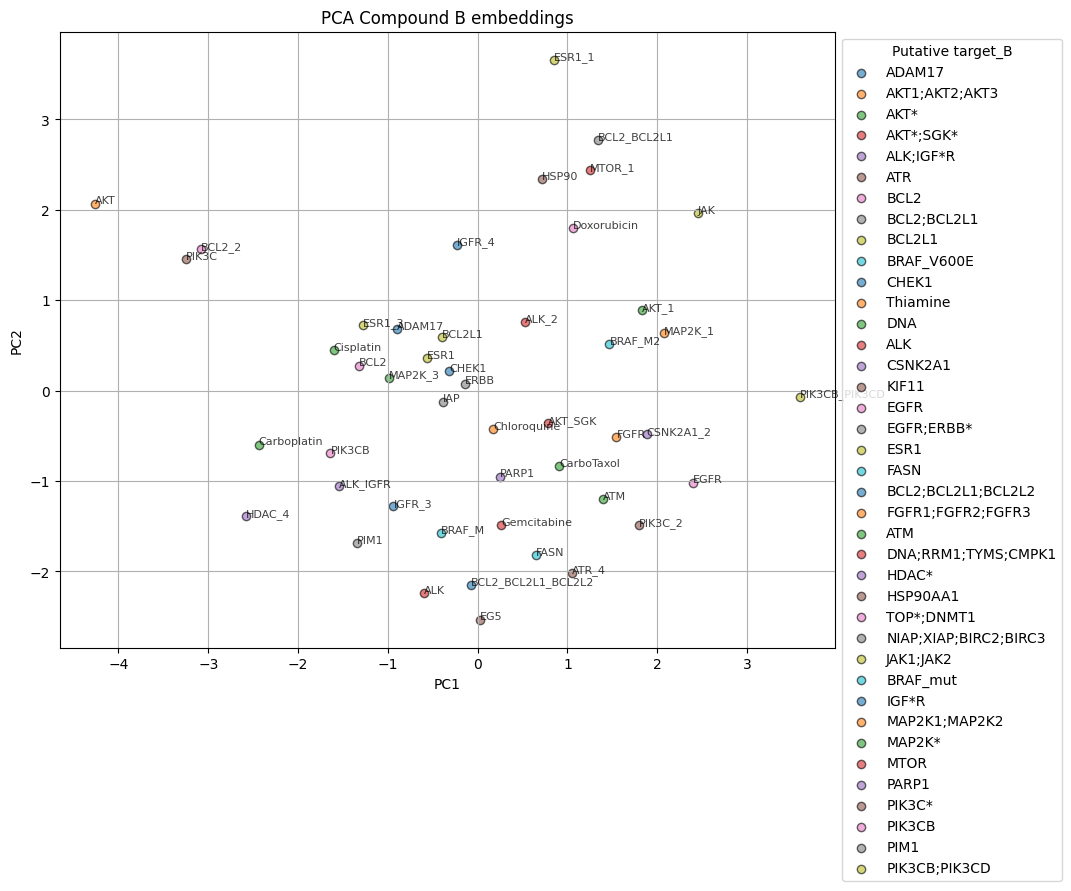

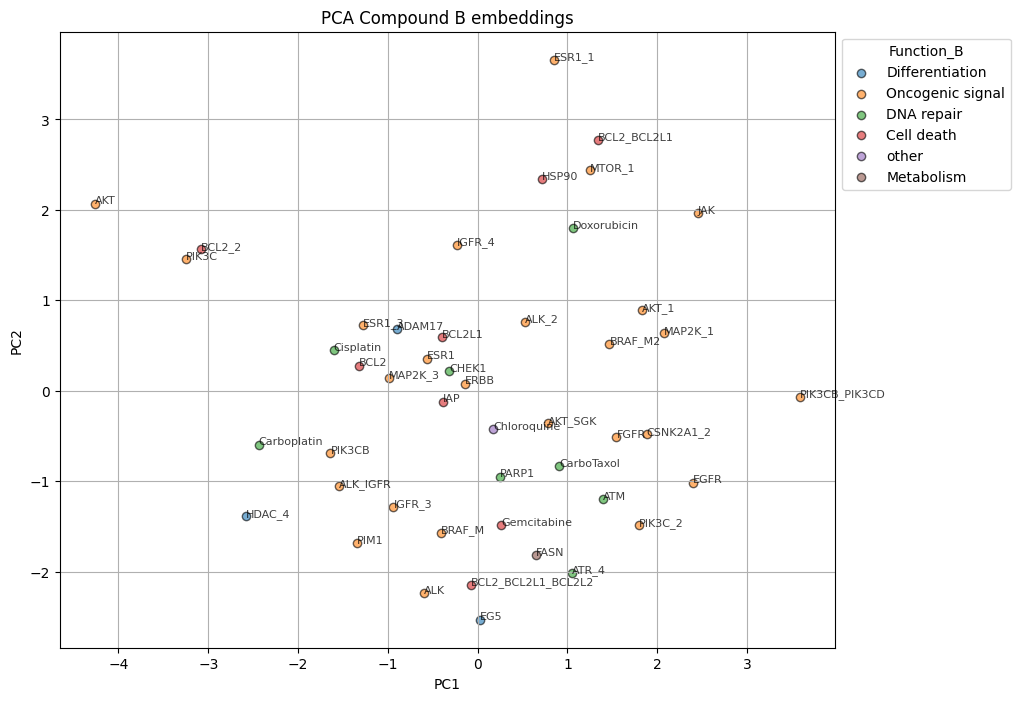

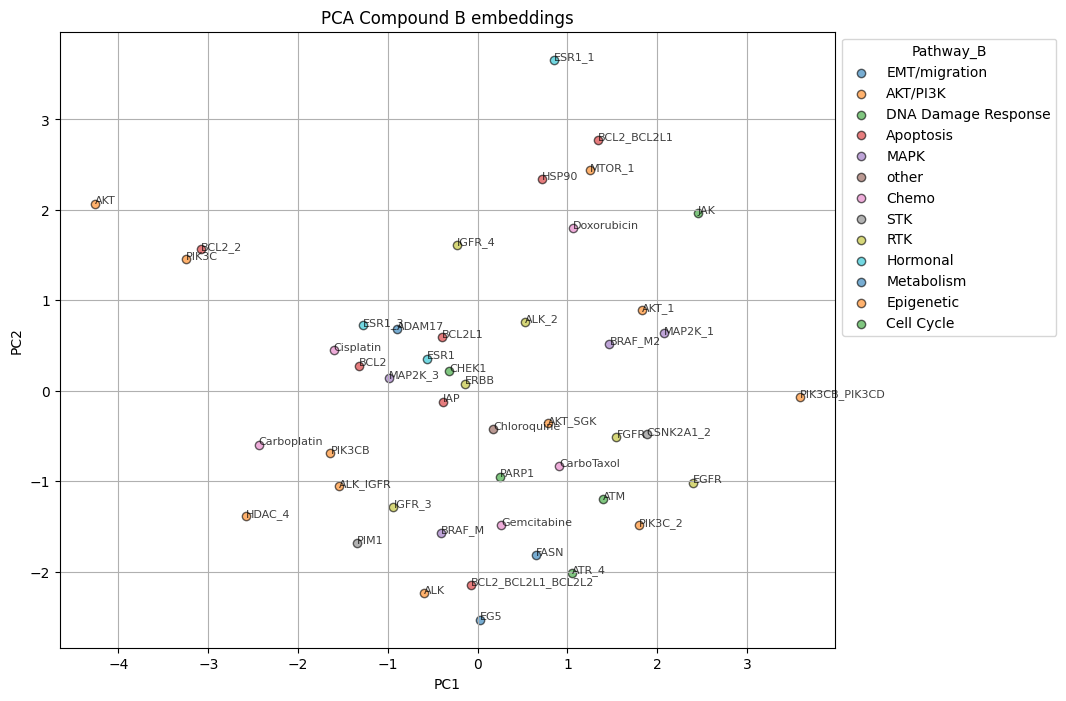

In [53]:
keyname_list = ['Putative target_B', 'Function_B', 'Pathway_B']

valuename = 'Compound B'

for keyname in keyname_list:
    key_list = full_dataset_df[keyname].unique().tolist()
    grouping_dict = dict()
    for key in key_list:
        grouping_dict[key] = full_dataset_df[full_dataset_df[keyname] == key][valuename].unique().tolist()

    plot_pca_embeddings(unique_embeddings_dict[valuename], valuename, 
                        groups_dict=grouping_dict, n_components=2, groups_name=keyname)

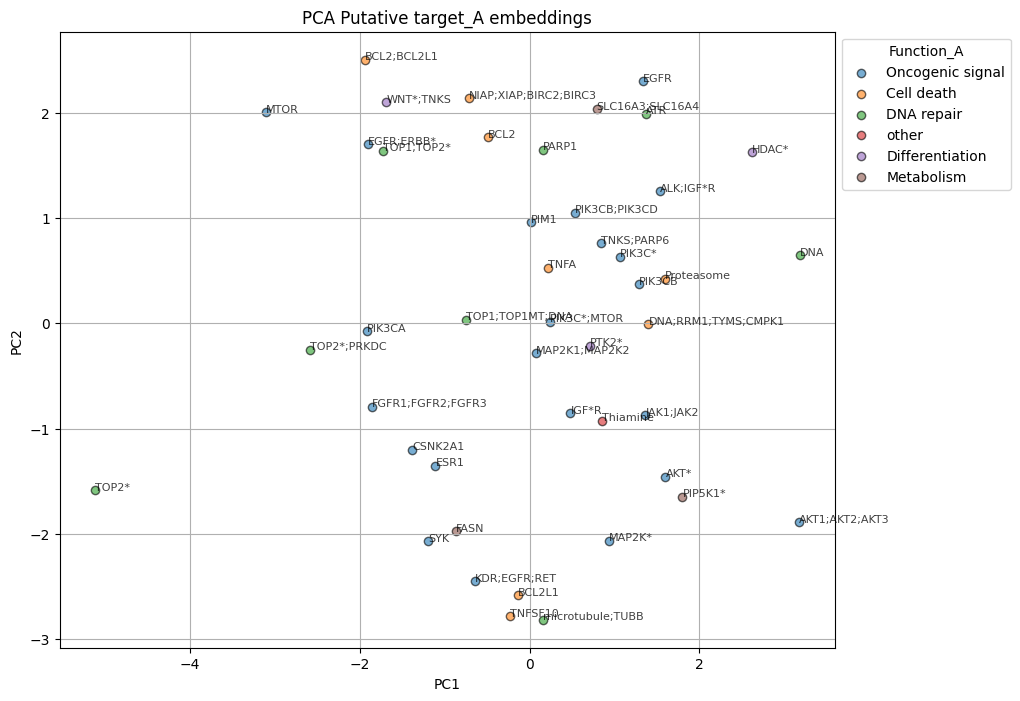

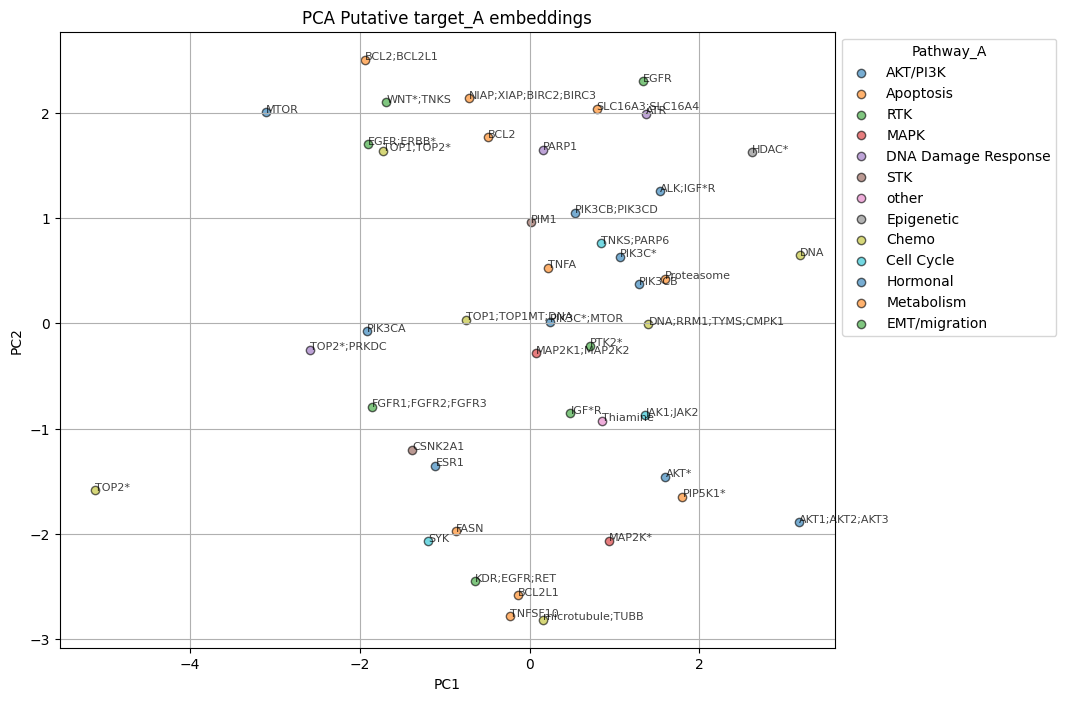

In [12]:
keyname_list = [ 'Function_A', 'Pathway_A']

valuename = 'Putative target_A'

for keyname in keyname_list:
    key_list = full_dataset_df[keyname].unique().tolist()
    grouping_dict = dict()
    for key in key_list:
        grouping_dict[key] = full_dataset_df[full_dataset_df[keyname] == key][valuename].unique().tolist()

    plot_pca_embeddings(unique_embeddings_dict[valuename], valuename, 
                        groups_dict=grouping_dict, n_components=2, groups_name=keyname)

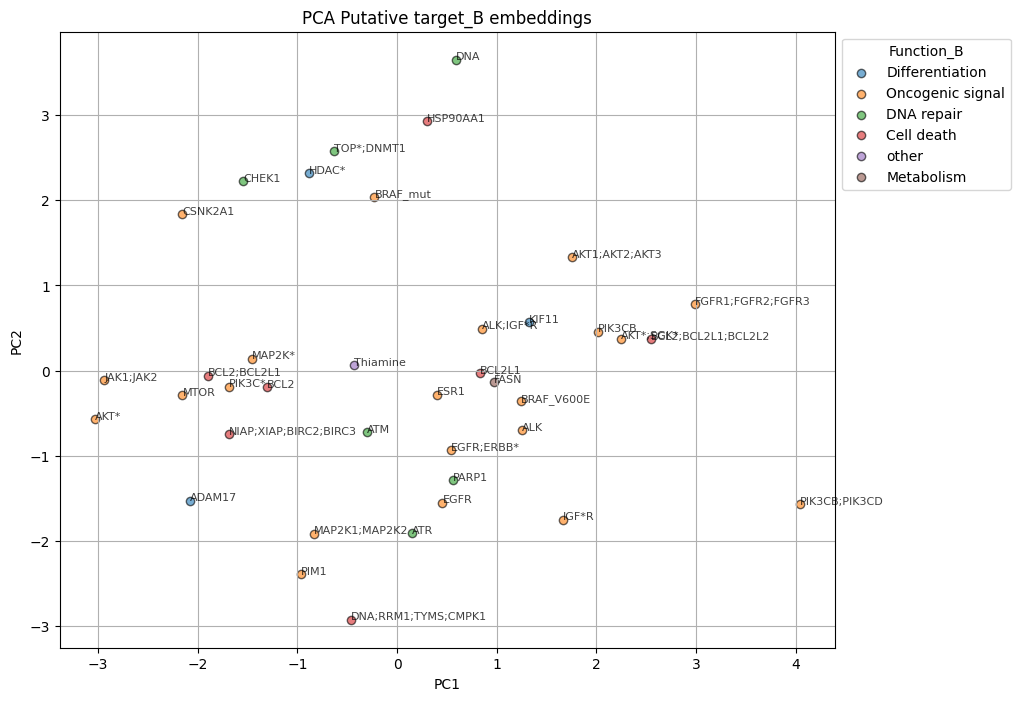

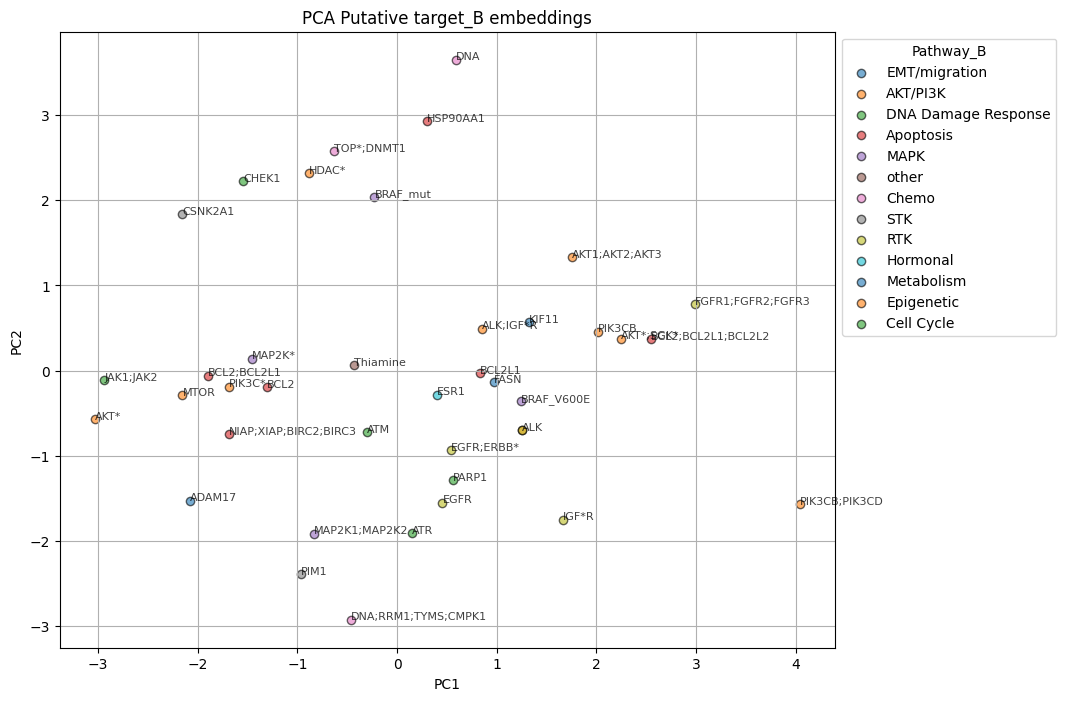

In [13]:
keyname_list = [ 'Function_B', 'Pathway_B']

valuename = 'Putative target_B'

for keyname in keyname_list:
    key_list = full_dataset_df[keyname].unique().tolist()
    grouping_dict = dict()
    for key in key_list:
        grouping_dict[key] = full_dataset_df[full_dataset_df[keyname] == key][valuename].unique().tolist()

    plot_pca_embeddings(unique_embeddings_dict[valuename], valuename, 
                        groups_dict=grouping_dict, n_components=2, groups_name=keyname)

## Save embeddings for every model

In [ ]:
X = datasets['train']['X'][categorical_cols]
print(X.columns)
X_trans = transformer.transform(X)
print(X_trans.columns)


# Dictionary to store unique embeddings for each element in each categorical column
unique_embeddings_dict = {}

for col in categorical_cols:
    # Identify embedding columns related to this categorical column
    embedding_cols = [c for c in X_trans.columns if c.startswith(f"{col}_embed_dim")]
    
    # Combine the original column with its embeddings
    combined_df = pd.concat([X[col].reset_index(drop=True), X_trans[embedding_cols].reset_index(drop=True)], axis=1)
    
    # Create a dictionary for this column where each key is a unique element, and value is the embedding as a numpy array
    col_embeddings = {val: group[embedding_cols].values[0] for val, group in combined_df.groupby(col)}
    
    # Store in the main dictionary
    unique_embeddings_dict[col] = col_embeddings
    
   

unique_embeddings_dict.keys()

In [4]:
# Path to the saved model checkpoint
model_path = "../models_weights/seed_42/CategoryEmbedding_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)


# Define the folder to save the dataframes
output_folder = "../data/embeddings/CategoryEmbedding_model/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Iterate over each category and create/save a DataFrame
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    
    # Prepare data for the DataFrame
    data = {
        category: [label for label in embeddings.keys()],    
    }
    # Add each embedding dimension as a separate column
    for dim in range(len(next(iter(embeddings.values())))):  # Assuming all embeddings have the same dimension
        data[f"embedding_dim_{dim}"] = [embedding[dim] for embedding in embeddings.values()]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_folder, f"{category}_embeddings.csv")
    df.to_csv(output_path, index=False)


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [9]:
# Path to the saved model checkpoint
model_path = "../models_weights/seed_42/AutoInt_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)


# Define the folder to save the dataframes
output_folder = "../data/embeddings/AutoInt_model/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Iterate over each category and create/save a DataFrame
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    
    # Prepare data for the DataFrame
    data = {
        category: [label for label in embeddings.keys()],    
    }
    # Add each embedding dimension as a separate column
    for dim in range(len(next(iter(embeddings.values())))):  # Assuming all embeddings have the same dimension
        data[f"embedding_dim_{dim}"] = [embedding[dim] for embedding in embeddings.values()]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_folder, f"{category}_embeddings.csv")
    df.to_csv(output_path, index=False)


2024-12-02 13:25:15,008 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-02 13:25:15,012 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

In [10]:
# Path to the saved model checkpoint
model_path = "../models_weights/seed_42/TabTransformer_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)


# Define the folder to save the dataframes
output_folder = "../data/embeddings/TabTransformer_model/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Iterate over each category and create/save a DataFrame
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    
    # Prepare data for the DataFrame
    data = {
        category: [label for label in embeddings.keys()],    
    }
    # Add each embedding dimension as a separate column
    for dim in range(len(next(iter(embeddings.values())))):  # Assuming all embeddings have the same dimension
        data[f"embedding_dim_{dim}"] = [embedding[dim] for embedding in embeddings.values()]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_folder, f"{category}_embeddings.csv")
    df.to_csv(output_path, index=False)


2024-12-02 13:25:33,985 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-02 13:25:33,988 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

## Save predictions for every model

In [10]:
# save predictions for every model 

# Path to the saved model checkpoint
model_path = "../models_weights/seed_0/CategoryEmbedding_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)

synergy_pred = model.predict(full_dataset_df)

full_dataset_df['synergy_pred'] = synergy_pred
full_dataset_df.to_csv('../data/synergy_score_predictions/CategoryEmbedding_pred.csv')

2024-12-10 16:15:06,852 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-10 16:15:06,858 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

In [11]:
# save predictions for every model 

# Path to the saved model checkpoint
model_path = "../models_weights/seed_0/AutoInt_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)

synergy_pred = model.predict(full_dataset_df)

full_dataset_df['synergy_pred'] = synergy_pred
full_dataset_df.to_csv('../data/synergy_score_predictions/AutoInt_pred.csv')

2024-12-10 16:15:13,642 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-10 16:15:13,647 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

In [12]:
# save predictions for every model 

# Path to the saved model checkpoint
model_path = "../models_weights/seed_0/TabTransformer_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)

synergy_pred = model.predict(full_dataset_df)

full_dataset_df['synergy_pred'] = synergy_pred
full_dataset_df.to_csv('../data/synergy_score_predictions/TabTransformer_pred.csv')

2024-12-10 16:15:35,560 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-10 16:15:35,565 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

# Export embeddings per column


In [8]:
X = full_dataset_df[categorical_cols]


3475

In [9]:
model_path = "../models_weights/seed_0/CategoryEmbedding_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)

X = full_dataset_df[categorical_cols]

print(X.columns)
X_trans = transformer.transform(X)
print(X_trans.columns)
pca_columns = ['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B']


# Dictionary to store unique embeddings for each element in each categorical column
unique_embeddings_dict = {}

for col in categorical_cols:
    # Identify embedding columns related to this categorical column
    embedding_cols = [c for c in X_trans.columns if c.startswith(f"{col}_embed_dim")]
    
    # Combine the original column with its embeddings
    combined_df = pd.concat([X[col].reset_index(drop=True), X_trans[embedding_cols].reset_index(drop=True)], axis=1)
    
    # Create a dictionary for this column where each key is a unique element, and value is the embedding as a numpy array
    col_embeddings = {val: group[embedding_cols].values[0] for val, group in combined_df.groupby(col)}
    
    # Store in the main dictionary
    unique_embeddings_dict[col] = col_embeddings
    
   

# Define the folder to save the dataframes
output_folder = "../data/embeddings/CategoryEmbedding_model/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Iterate over each category and create/save a DataFrame
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    
    # Prepare data for the DataFrame
    data = {
        category: [label for label in embeddings.keys()],    
    }
    # Add each embedding dimension as a separate column
    for dim in range(len(next(iter(embeddings.values())))):  # Assuming all embeddings have the same dimension
        data[f"embedding_dim_{dim}"] = [embedding[dim] for embedding in embeddings.values()]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_folder, f"{category}_embeddings.csv")
    df.to_csv(output_path, index=False)


2024-12-12 09:43:22,657 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-12 09:43:22,661 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Output()

Index(['Cell line name', 'Compound A', 'Compound B',
       'GDSC tissue descriptor 2', 'MSI', 'Growth properties',
       'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B',
       'Function_B', 'Pathway_B'],
      dtype='object')


Index(['Cell line name_embed_dim_0', 'Cell line name_embed_dim_1',
       'Cell line name_embed_dim_2', 'Cell line name_embed_dim_3',
       'Cell line name_embed_dim_4', 'Cell line name_embed_dim_5',
       'Cell line name_embed_dim_6', 'Cell line name_embed_dim_7',
       'Cell line name_embed_dim_8', 'Cell line name_embed_dim_9',
       ...
       'Function_B_embed_dim_1', 'Function_B_embed_dim_2',
       'Function_B_embed_dim_3', 'Pathway_B_embed_dim_0',
       'Pathway_B_embed_dim_1', 'Pathway_B_embed_dim_2',
       'Pathway_B_embed_dim_3', 'Pathway_B_embed_dim_4',
       'Pathway_B_embed_dim_5', 'Pathway_B_embed_dim_6'],
      dtype='object', length=170)


In [16]:
model_path = "../models_weights/seed_0/AutoInt_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)


X = full_dataset_df[categorical_cols]
print(X.columns)
X_trans = transformer.transform(X)
print(X_trans.columns)
pca_columns = ['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B']


# Dictionary to store unique embeddings for each element in each categorical column
unique_embeddings_dict = {}

for col in categorical_cols:
    # Identify embedding columns related to this categorical column
    embedding_cols = [c for c in X_trans.columns if c.startswith(f"{col}_embed_dim")]
    
    # Combine the original column with its embeddings
    combined_df = pd.concat([X[col].reset_index(drop=True), X_trans[embedding_cols].reset_index(drop=True)], axis=1)
    
    # Create a dictionary for this column where each key is a unique element, and value is the embedding as a numpy array
    col_embeddings = {val: group[embedding_cols].values[0] for val, group in combined_df.groupby(col)}
    
    # Store in the main dictionary
    unique_embeddings_dict[col] = col_embeddings
    
   

# Define the folder to save the dataframes
output_folder = "../data/embeddings/AutoInt_model/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Iterate over each category and create/save a DataFrame
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    
    # Prepare data for the DataFrame
    data = {
        category: [label for label in embeddings.keys()],    
    }
    # Add each embedding dimension as a separate column
    for dim in range(len(next(iter(embeddings.values())))):  # Assuming all embeddings have the same dimension
        data[f"embedding_dim_{dim}"] = [embedding[dim] for embedding in embeddings.values()]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_folder, f"{category}_embeddings.csv")
    df.to_csv(output_path, index=False)


2024-12-12 09:45:30,447 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-12 09:45:30,451 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Output()

Index(['Cell line name', 'Compound A', 'Compound B',
       'GDSC tissue descriptor 2', 'MSI', 'Growth properties',
       'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B',
       'Function_B', 'Pathway_B'],
      dtype='object')


Index(['Cell line name_embed_dim_0', 'Cell line name_embed_dim_1',
       'Cell line name_embed_dim_2', 'Cell line name_embed_dim_3',
       'Cell line name_embed_dim_4', 'Cell line name_embed_dim_5',
       'Cell line name_embed_dim_6', 'Cell line name_embed_dim_7',
       'Cell line name_embed_dim_8', 'Cell line name_embed_dim_9',
       ...
       'Pathway_B_embed_dim_6', 'Pathway_B_embed_dim_7',
       'Pathway_B_embed_dim_8', 'Pathway_B_embed_dim_9',
       'Pathway_B_embed_dim_10', 'Pathway_B_embed_dim_11',
       'Pathway_B_embed_dim_12', 'Pathway_B_embed_dim_13',
       'Pathway_B_embed_dim_14', 'Pathway_B_embed_dim_15'],
      dtype='object', length=192)


In [14]:
model_path = "../models_weights/seed_0/TabTransformer_model.ckpt/"

device = torch.device("cpu")
# Load the model
model = TabularModel.load_model(model_path, map_location=device)
transformer = CategoricalEmbeddingTransformer(model)


X = full_dataset_df[categorical_cols]
print(X.columns)
X_trans = transformer.transform(X)
print(X_trans.columns)
pca_columns = ['Cell line name', 'Compound A', 'Compound B', 'GDSC tissue descriptor 2', 'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B', 'Function_B', 'Pathway_B']


# Dictionary to store unique embeddings for each element in each categorical column
unique_embeddings_dict = {}

for col in categorical_cols:
    # Identify embedding columns related to this categorical column
    embedding_cols = [c for c in X_trans.columns if c.startswith(f"{col}_embed_dim")]
    
    # Combine the original column with its embeddings
    combined_df = pd.concat([X[col].reset_index(drop=True), X_trans[embedding_cols].reset_index(drop=True)], axis=1)
    
    # Create a dictionary for this column where each key is a unique element, and value is the embedding as a numpy array
    col_embeddings = {val: group[embedding_cols].values[0] for val, group in combined_df.groupby(col)}
    
    # Store in the main dictionary
    unique_embeddings_dict[col] = col_embeddings
    
   

# Define the folder to save the dataframes
output_folder = "../data/embeddings/TabTransformer_model/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Iterate over each category and create/save a DataFrame
for category in pca_columns:
    embeddings = unique_embeddings_dict[category]
    
    # Prepare data for the DataFrame
    data = {
        category: [label for label in embeddings.keys()],    
    }
    # Add each embedding dimension as a separate column
    for dim in range(len(next(iter(embeddings.values())))):  # Assuming all embeddings have the same dimension
        data[f"embedding_dim_{dim}"] = [embedding[dim] for embedding in embeddings.values()]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    # Save the DataFrame as a CSV file
    output_path = os.path.join(output_folder, f"{category}_embeddings.csv")
    df.to_csv(output_path, index=False)


2024-12-12 09:44:54,168 - {pytorch_tabular.tabular_model:167} - INFO - Experiment Tracking is turned off

2024-12-12 09:44:54,171 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

Output()

Index(['Cell line name', 'Compound A', 'Compound B',
       'GDSC tissue descriptor 2', 'MSI', 'Growth properties',
       'Putative target_A', 'Function_A', 'Pathway_A', 'Putative target_B',
       'Function_B', 'Pathway_B'],
      dtype='object')


Index(['Cell line name_embed_dim_0', 'Cell line name_embed_dim_1',
       'Cell line name_embed_dim_2', 'Cell line name_embed_dim_3',
       'Cell line name_embed_dim_4', 'Cell line name_embed_dim_5',
       'Cell line name_embed_dim_6', 'Cell line name_embed_dim_7',
       'Cell line name_embed_dim_8', 'Cell line name_embed_dim_9',
       ...
       'Pathway_B_embed_dim_22', 'Pathway_B_embed_dim_23',
       'Pathway_B_embed_dim_24', 'Pathway_B_embed_dim_25',
       'Pathway_B_embed_dim_26', 'Pathway_B_embed_dim_27',
       'Pathway_B_embed_dim_28', 'Pathway_B_embed_dim_29',
       'Pathway_B_embed_dim_30', 'Pathway_B_embed_dim_31'],
      dtype='object', length=384)
